In [58]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import levene

import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_json('all_filtered.json')

In [6]:
data['week'] = data['date'].dt.isocalendar().week

# Статистика

In [12]:
data['post_id'].nunique()

6413

In [14]:
#группиурем так, чтобы каждому посту соответствовало стандартное отклонение тональности комментов под ним
grouped_tone = data.groupby(['post_id', 'topic', 'month'])['tone_score'].std().reset_index(name='std_sentiment')
grouped_tone = grouped_tone.fillna(0)

In [16]:
grouped_tone['topic'].value_counts()

topic
svo            1886
usa             921
crime           830
putin           725
diplomacy       506
middle_east     473
emergency       398
economics       325
protests        193
soc_pol         156
Name: count, dtype: int64

#### уменьшила объем постов в "svo"

In [18]:
a = grouped_tone[grouped_tone['topic'] != 'svo']
b = grouped_tone[grouped_tone['topic'] == 'svo'].sample(n = max(grouped_tone[grouped_tone['topic'] != 'svo']['topic'].value_counts()), random_state = 42)

In [20]:
df = pd.concat([a,b])

In [65]:
df.to_excel('grouped_filtered_data.xlsx', index = False)

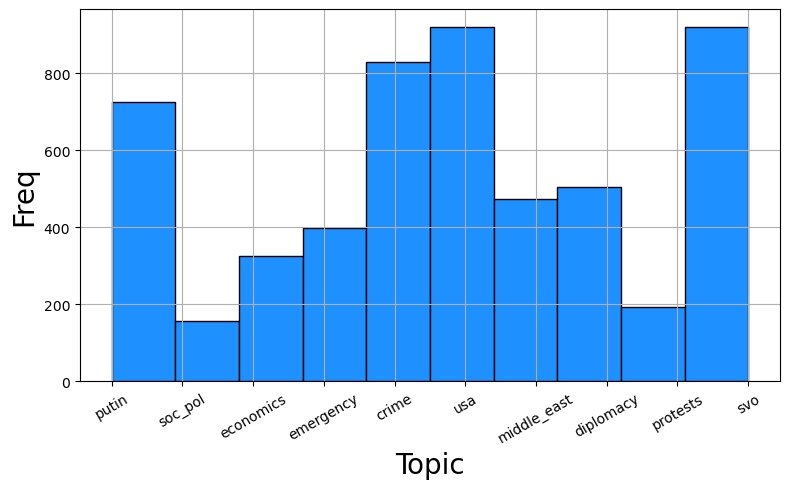

In [24]:
#этот график вставить в текст. тут количество постов по темам в итоговом датасете
plt.figure(figsize = (8,5))
plt.hist(df['topic'], bins =df['topic'].nunique(), color = 'dodgerblue', edgecolor = 'black')
plt.xlabel('Topic', size = 20)
plt.ylabel('Freq', size = 20)
plt.xticks(rotation= 30, ha = 'center') 
plt.grid()
plt.tight_layout() ;

In [28]:
from scipy.stats import kstest, norm
groups = {topic: df[df['topic'] == topic]['std_sentiment'] for topic in df['topic'].unique()}
print("Тест Колмогорова-Смирнова на нормальность tone_score по темам:")
for topic, group in groups.items():
    mean = group.mean()
    std = group.std(ddof=1)
    standardized_group = (group - mean) / std
    stat, p = kstest(standardized_group, 'norm')
    
    print(f"\nТема: {topic}")
    print(f"p-value: {p:.4f}")
    if p < 0.05:
        print("данные не распределены нормально")
    else:
        print("данные могут быть распределены нормально")

Тест Колмогорова-Смирнова на нормальность tone_score по темам:

Тема: putin
p-value: 0.0023
данные не распределены нормально

Тема: soc_pol
p-value: 0.0523
данные могут быть распределены нормально

Тема: economics
p-value: 0.0374
данные не распределены нормально

Тема: emergency
p-value: 0.0046
данные не распределены нормально

Тема: crime
p-value: 0.0001
данные не распределены нормально

Тема: usa
p-value: 0.0006
данные не распределены нормально

Тема: middle_east
p-value: 0.0214
данные не распределены нормально

Тема: diplomacy
p-value: 0.0539
данные могут быть распределены нормально

Тема: protests
p-value: 0.9307
данные могут быть распределены нормально

Тема: svo
p-value: 0.0002
данные не распределены нормально


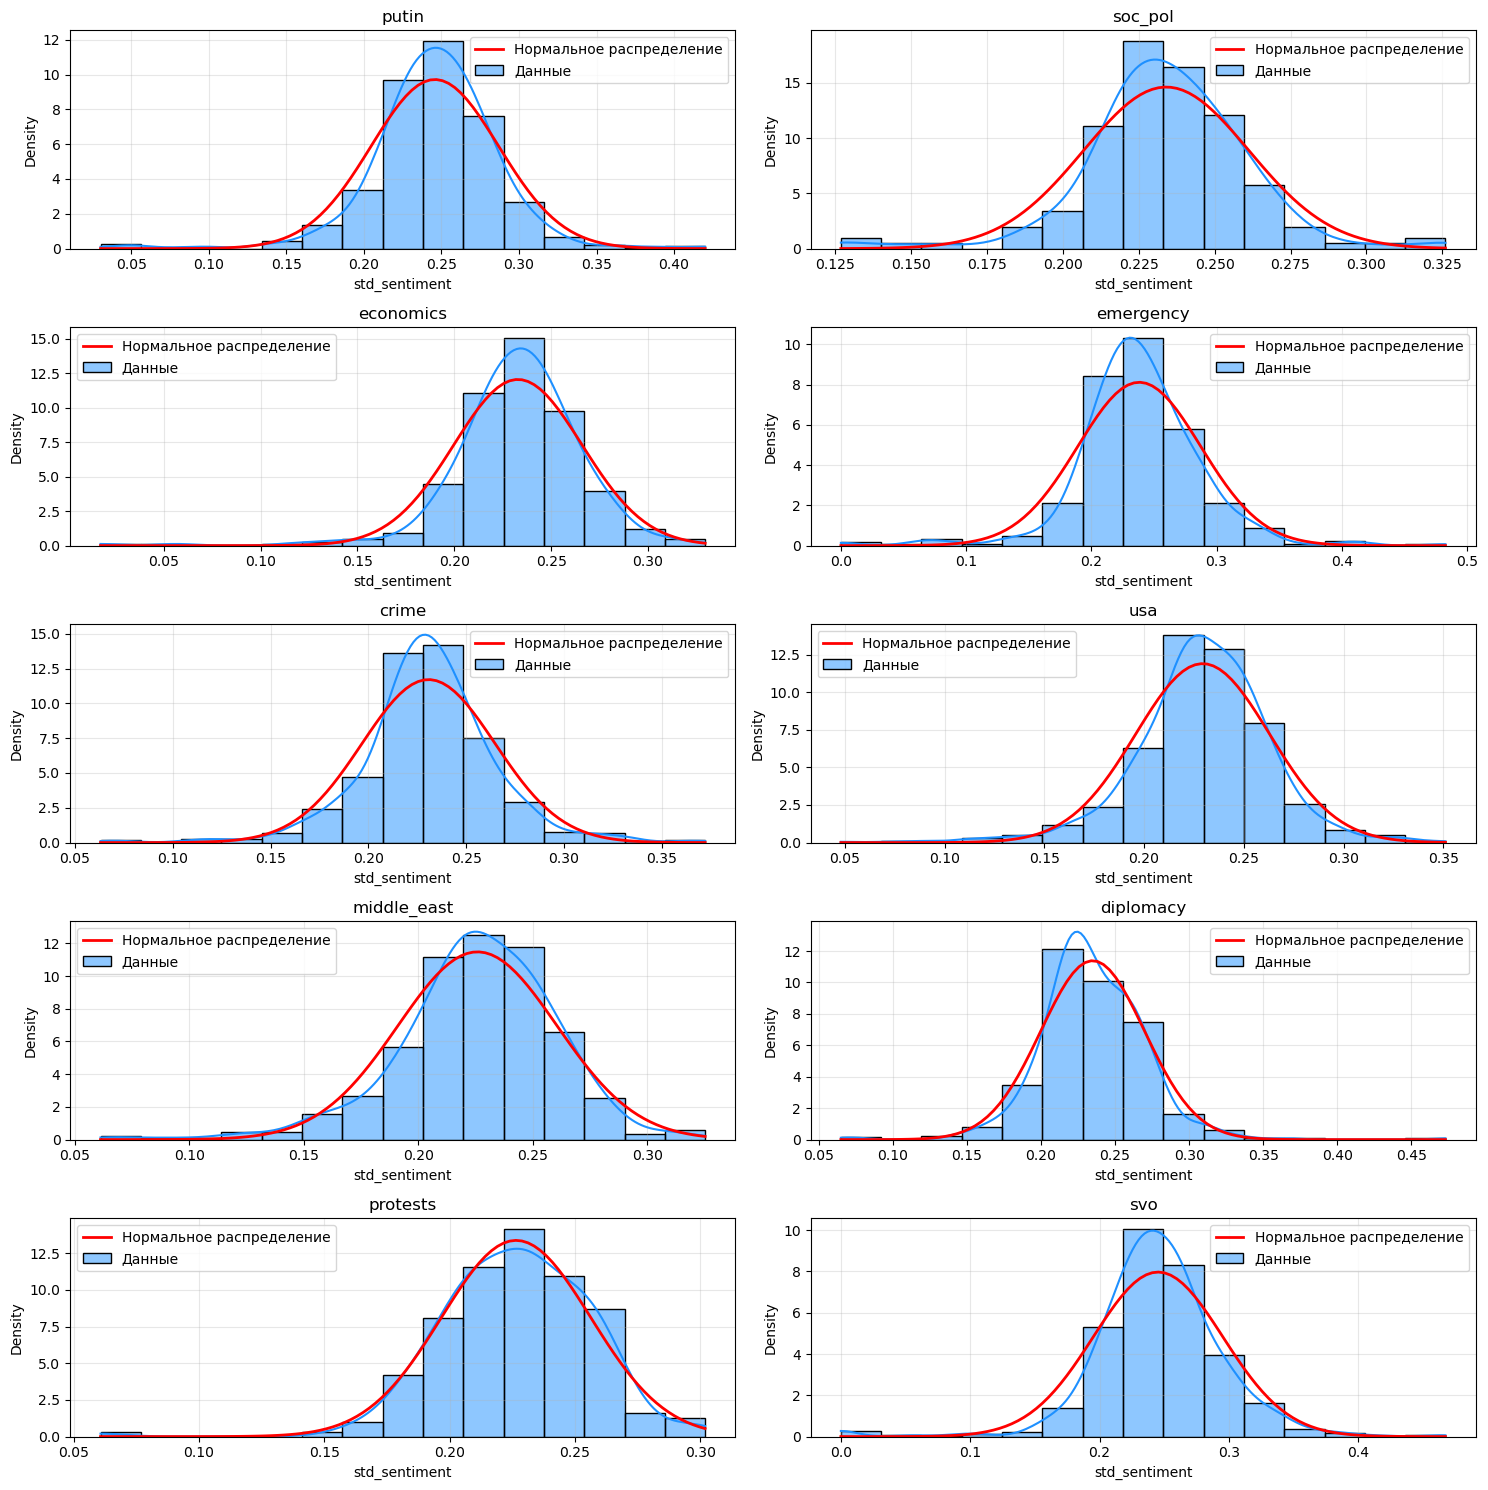

In [30]:
plt.figure(figsize=(15, 15))

for idx, (topic, group) in enumerate(groups.items()):
    plt.subplot(5, 2, idx + 1)  
    sns.histplot(data=group, bins=15, stat='density', kde=True, color='dodgerblue', label='Данные')
    mean = group.mean()
    std = group.std(ddof=1)
    x = np.linspace(min(group), max(group), 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'r-', lw=2, label='Нормальное распределение')
    plt.title(f'{topic}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()  

In [32]:
from scipy.stats import kruskal
groups_tone = [df[df['topic'] == topic]['std_sentiment'] for topic in df['topic'].unique()]
stat, p_value = kruskal(*groups_tone)

print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("p-value < 0.05: Есть статистически значимые различия между группами.")
else:
    print("p-value >= 0.05: Нет статистически значимых различий между группами.")

p-value: 0.0000
p-value < 0.05: Есть статистически значимые различия между группами.


In [34]:
levene_stat, levene_p = levene(*groups_tone)

print(f"Статистика: {levene_stat:.4f}")
print(f"p-значение: {levene_p:.4f}")
if levene_p < 0.05:
     print("Отвергаем нулевую гипотезу: дисперсии std_sentiment различаются между темами.")
else:
     print("Не отвергаем нулевую гипотезу: дисперсии std_sentiment могут быть равны.")

print("\nОписательные статистики по группам:")
for topic in grouped_tone['topic'].unique():
    group_data_tone = df[df['topic'] == topic]['std_sentiment']
    print(f"{topic}: Среднее = {group_data_tone.mean():.4f}, Дисперсия = {group_data_tone.var(ddof=1):.4f}")

Статистика: 16.3203
p-значение: 0.0000
Отвергаем нулевую гипотезу: дисперсии std_sentiment различаются между темами.

Описательные статистики по группам:
putin: Среднее = 0.2458, Дисперсия = 0.0017
soc_pol: Среднее = 0.2341, Дисперсия = 0.0007
svo: Среднее = 0.2452, Дисперсия = 0.0025
economics: Среднее = 0.2328, Дисперсия = 0.0011
emergency: Среднее = 0.2382, Дисперсия = 0.0024
crime: Среднее = 0.2307, Дисперсия = 0.0012
usa: Среднее = 0.2294, Дисперсия = 0.0011
middle_east: Среднее = 0.2259, Дисперсия = 0.0012
diplomacy: Среднее = 0.2349, Дисперсия = 0.0012
protests: Среднее = 0.2265, Дисперсия = 0.0009


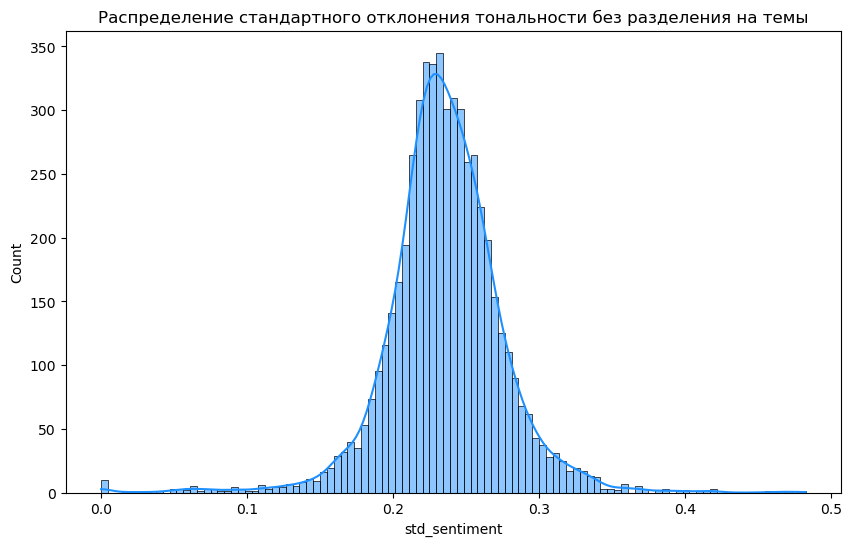

In [36]:
plt.figure(figsize = (10,6))
sns.histplot(df['std_sentiment'], kde=True, color='dodgerblue')
plt.title('Распределение стандартного отклонения тональности без разделения на темы');

In [38]:
df['std_sentiment'].std()

0.039716484185821264

In [40]:
np.median(np.array(df['std_sentiment']))

0.23463913493807126

In [42]:
np.mean(np.array(df['std_sentiment']))

0.2355230815932401

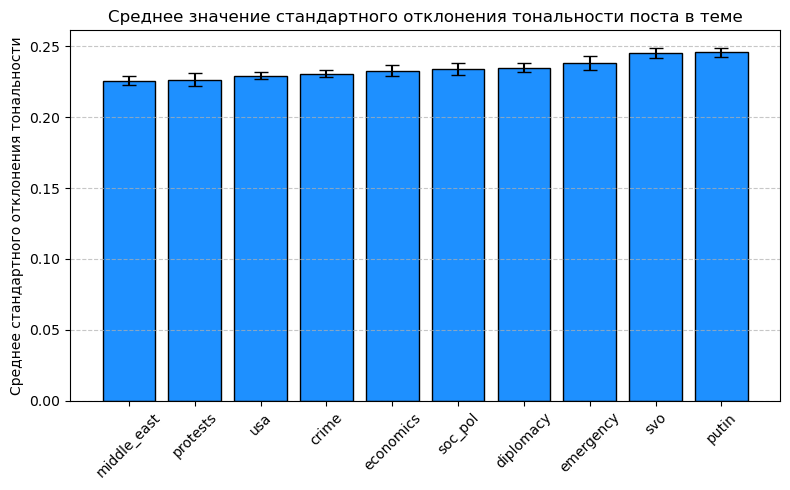

In [46]:
summary = df.groupby('topic')['std_sentiment'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=True)
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = 2 * summary['sem']
plt.figure(figsize=(8, 5))
plt.bar(summary.index, summary['mean'], yerr=summary['ci95'],
        color='dodgerblue', edgecolor='black', capsize=5)

plt.title('Среднее значение стандартного отклонения тональности поста в теме')
plt.ylabel('Среднее стандартного отклонения тональности')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [48]:
from scipy.stats import chi2

summary['variance'] = summary['std']**2
alpha = 0.05 
summary['ci_lower'] = np.nan
summary['ci_upper'] = np.nan

for topic in summary.index:
    n = summary.loc[topic, 'count']  
    s2 = summary.loc[topic, 'variance']  
    dfree = n - 1 
    if dfree > 0:  
        chi2_lower = chi2.ppf(1 - alpha/2, dfree)  
        chi2_upper = chi2.ppf(alpha/2, dfree) 
        summary.loc[topic, 'ci_lower'] = (dfree * s2) / chi2_lower
        summary.loc[topic, 'ci_upper'] = (dfree * s2) / chi2_upper

In [52]:
summary.head()

,mean,std,count,sem,ci95,variance,ci_lower,ci_upper
topic,,,,,,,,
middle_east,0.225855,0.034760,473,0.001598,0.003197,0.001208,0.001068,0.001379
protests,0.226547,0.029824,193,0.002147,0.004294,0.000889,0.000735,0.001098
usa,0.229364,0.033544,921,0.001105,0.002211,0.001125,0.001029,0.001236
crime,0.230733,0.034062,830,0.001182,0.002365,0.001160,0.001056,0.001281
economics,0.232815,0.033080,325,0.001835,0.003670,0.001094,0.000944,0.001284


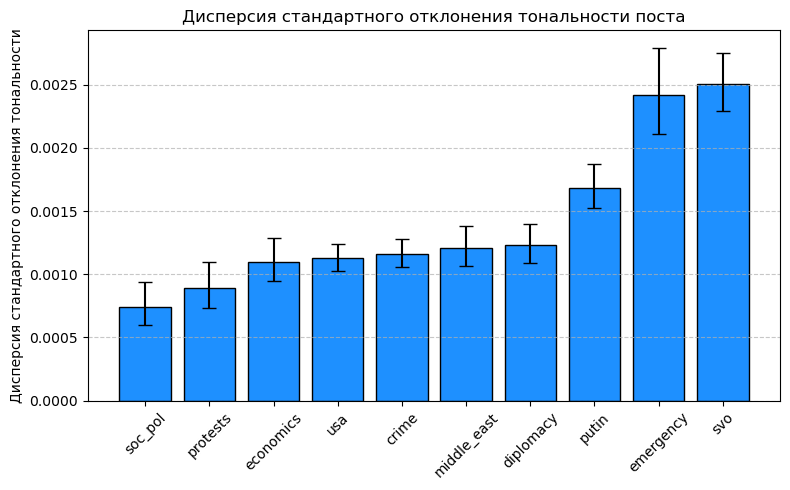

In [54]:
summary = summary.sort_values(by='std', ascending=True)
plt.figure(figsize=(8, 5))
plt.bar(summary.index, summary['variance'],
               yerr=[summary['variance'] - summary['ci_lower'], summary['ci_upper'] - summary['variance']],
               color='dodgerblue', edgecolor='black', capsize=5)

plt.title('Дисперсия стандартного отклонения тональности поста')
plt.ylabel('Дисперсия стандартного отклонения тональности')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

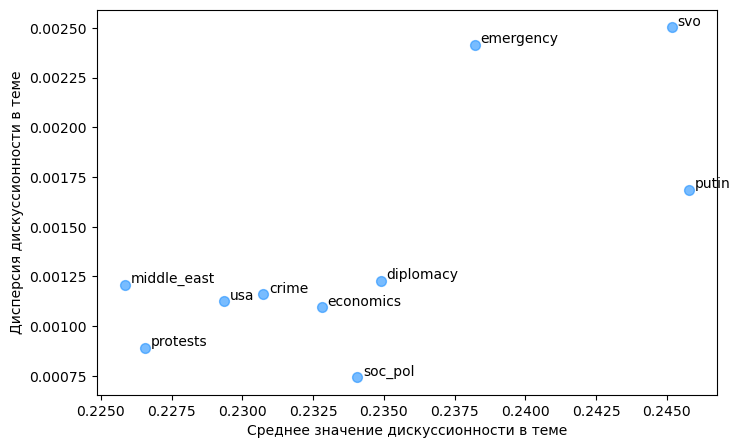

In [60]:
plt.figure(figsize=(8, 5))
plt.scatter(summary['mean'], summary['std']**2, color='dodgerblue', s=50, alpha=0.6)

for topic in summary.index:
    i = summary.index.get_loc(topic)  
    plt.text(
        x=summary['mean'][i] + 0.0002,  
        y=summary['std'][i]**2 + 0.00001,  
        s=topic,  
        fontsize=10,
        ha='left',
    )
plt.xlabel('Среднее значение дискуссионности в теме')
plt.ylabel('Дисперсия дискуссионности в теме')
plt.show();